In [1]:
# data comes from http://web.stanford.edu/~ericyi/project_page/part_annotation/index.html
from pyntcloud import PyntCloud
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
if sys.platform == 'darwin':
    data_path = os.getcwd() + "/PartAnnotation"
else:
    data_path = os.getcwd() + "\\PartAnnotation"

# Data explorer

Data comes from http://web.stanford.edu/~ericyi/project_page/part_annotation/index.html

Rename the folder into proper class names if you want to see the results properly. It won't affect the results but it is better to see a proper label rather than random numbers.

In [2]:
def count_data(data_path):
    """
    Will read all the data under specific data path
    
    Return:
        cate: a dict which all the names encoded by numbers
        label: a dict contains all the number & name mappings.
    """
    cate = {}
    label = {}
    count = 0
    for entry in os.scandir(data_path):
        if entry.is_dir():
            for pts_data in os.scandir(os.path.join(data_path, entry.name, 'points')):
                if count in cate:
                    cate.update({count: cate.get(count) + 1})
                else:
                    cate.update({count: 1})
                    label.update({count: entry.name})
            count += 1
    return cate, label

In [3]:
cate, label = count_data(data_path)

In [4]:
print(cate)
print(label)

{0: 4045, 1: 83, 2: 56, 3: 7497, 4: 6778, 5: 73, 6: 797, 7: 424, 8: 2318, 9: 460, 10: 337, 11: 214, 12: 307, 13: 85, 14: 152, 15: 8509}
{0: 'airplane', 1: 'bag', 2: 'cap', 3: 'car', 4: 'chair', 5: 'earphone', 6: 'guitar', 7: 'knife', 8: 'lamp', 9: 'laptop', 10: 'motorbike', 11: 'mug', 12: 'pistol', 13: 'rocket', 14: 'skateboard', 15: 'table'}


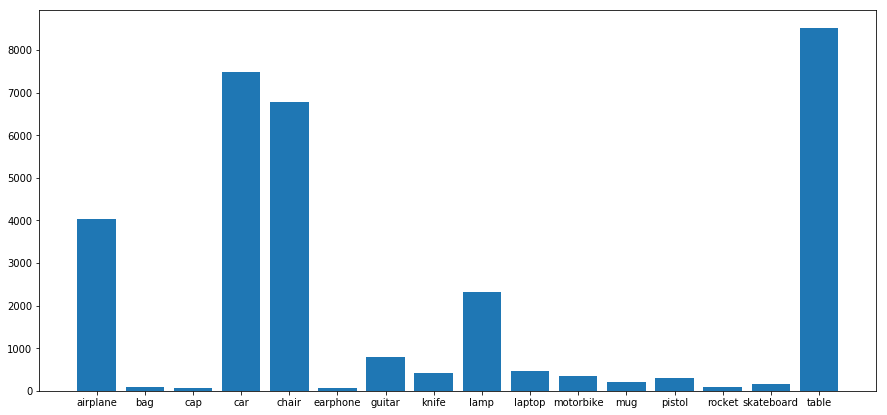

In [5]:
fig = plt.figure(figsize=(15,7))

plt.bar(list(cate), height=list(cate.values()))
plt.xticks(list(cate), list(label.values()))
plt.show()

# Data Imbalance problem

Method 1: pick same amount of samples from each class

Method 2: Repeat small sample classes 10 times or so.

    - Add Gaussian Noise
    - Add invariant transformations(shift left, right, rotate, etc.)

Method 2 is more preferable. since less variance, more data

In [6]:
def find_data(data_path, max_file_num=None, folder_filter=(None, None)):
    """
    Find file in each folder according to the 'data_path'.
    
    Giving the max number of files via `max_file_num`, it will read first `max_file_num` in each folder. Read all if there is no enough file inside.
    
    `folder_filter` is a tuple like (100, 2000) which indicates the number of files will between 100 and 2000.
    """
    
    min_th, max_th = folder_filter
    if max_file_num is not None and folder_filter is not None:
        if min_th is not None:
            assert(max_file_num > min_th), "`max_file_num` should be greater than `" + min_th + "` in " + folder_filter
        
    data = []
    label = []
    for entry in os.scandir(data_path):
        if entry.is_dir():
            target_dir_path = os.path.join(data_path, entry.name, 'points')
            path, dirs, files = os.walk(target_dir_path).__next__()
            file_count = len(files)
            if (min_th is None or file_count >= min_th) and (max_th is None or file_count <= max_th):
                count = 0
                for pts_data in os.scandir(target_dir_path):
                    if (max_file_num is None) or (count < max_file_num):
                        data.append(os.path.join(data_path, entry.name, 'points', pts_data.name))
                        label.append(entry.name)
                        count += 1
                    else:
                        break
    return data, label

In [7]:
data, label = find_data(data_path, folder_filter=(2000, None))

# Plot

In [41]:
my_point_cloud = PyntCloud.from_file(data[120], sep=" ", header=0, names=["x","y","z"])

In [42]:
print(len(label))
label[30]

29147


'table'

In [43]:
my_point_cloud.plot(point_size=0.005)

# Data augmentation
- Rotate
- Squeeze
- Gaussian Noise

### Rotate

In [11]:
def rotate(pts, axis=0, angle_degree=30):
    """
    Rotate the pts point cloud by a specific angle.
    
    axis = 0 : rotate around x-axis
    axis = 1 : rotate around y-axis
    axis = 2 : rotate around z-axis
    
    angle_degree : how much degree you want to rotate the point cloud.
    
    Algorithm comes in: https://uk.mathworks.com/matlabcentral/answers/123763-how-to-rotate-entire-3d-data-with-x-y-z-values-along-a-particular-axis-say-x-axis
    """
    if axis == 0: 
        return rotate_by_x(pts, angle_degree)
    if axis == 1: 
        return rotate_by_y(pts, angle_degree)
    if axis == 2: 
        return rotate_by_z(pts, angle_degree)
    
def rotate_by_x(pts, angle_degree=30):
    import numpy as np
    degree = np.deg2rad(angle_degree)
    res = np.empty(pts.shape)
    for index, point in enumerate(pts):
        new_point = np.zeros(3)
        new_point[0] = point[0] # x
        new_point[1] = point[1]*np.cos(degree) - point[2]*np.sin(degree) # y
        new_point[2] = point[1]*np.sin(degree) + point[2]*np.cos(degree) # z
        res[index] = new_point
        
    return res

    
def rotate_by_y(pts, angle_degree=30):
    import numpy as np
    degree = np.deg2rad(angle_degree)
    res = np.empty(pts.shape)
    for index, point in enumerate(pts):
        new_point = np.zeros(3)
        new_point[0] = point[0]*np.cos(degree) + point[2]*np.sin(degree) # x
        new_point[1] = point[1] # y
        new_point[2] = point[2]*np.cos(degree) - point[0]*np.sin(degree) # z
        res[index] = new_point
        
    return res

    
def rotate_by_z(pts, angle_degree=30):
    import numpy as np
    degree = np.deg2rad(angle_degree)
    res = np.empty(pts.shape)
    for index, point in enumerate(pts):
        new_point = np.zeros(3)
        new_point[0] = point[0]*np.cos(degree) - point[1]*np.sin(degree) # x
        new_point[1] = point[0]*np.sin(degree) + point[1]*np.cos(degree) # y
        new_point[2] = point[2] # z
        res[index] = new_point
        
    return res

In [12]:
def write_to_file(xyz, filename='xyz'):
    import os
    file = open(os.path.join(os.getcwd(), filename + ".pts"), "w") 
    
    for point in xyz:
        st = ""
        for item in point:
            st += str(item) + " "
        file.write(st.strip() + "\n")

    file.close() 

In [13]:
rotated_point_cloud = rotate(my_point_cloud.xyz, angle_degree=180)
write_to_file(rotated_point_cloud)

In [14]:
rotated_point_cloud_file = PyntCloud.from_file(os.path.join(os.getcwd(), "xyz.pts"), sep=" ", header=0, names=["x","y","z"])
rotated_point_cloud_file.plot(point_size=0.005)

In [15]:
def voxelize3D(pts, dim=[1,1,1]):
    """
    pts: receives .pts cloud point data. 2D array, arbitary sized X,Y,Z pairs. (We will only take x,y,z into account for now)
    dim: dimensioin of output voxelized data
    
    This function will locate the grid cube and calculate the density of each cube.
    The output will be normalized values.
    """
    assert(pts.shape[1]>=3), "pts file should contain at least x,y,z coordinate"
    assert(len(dim)==3), "Please provide 3-d grid size like [32,32,32]"
    
    # move all the axis to positive area.
    minimum_val = [pts[0][0], pts[0][1], pts[0][2]]

    # find the smallest 
    for pair in pts:
        if pair[0] < minimum_val[0]:
            minimum_val[0] = pair[0]
        if pair[1] < minimum_val[1]:
            minimum_val[1] = pair[1]
        if pair[2] < minimum_val[2]:
            minimum_val[2] = pair[2]
            
    # move it to first quadrant 
    rectified_pts = np.empty(pts.shape)
    for index, pair in enumerate(pts):
        point = np.zeros(3)
        point[0] = pair[0] - minimum_val[0]
        point[1] = pair[1] - minimum_val[1]
        point[2] = pair[2] - minimum_val[2]
        rectified_pts[index] = point
    
    # biggest value in each axis 
    maximum_val = pts[0][0]
    
    for pair in rectified_pts:
        for val in pair:
            if val > maximum_val:
                maximum_val = val
     
    # normalize all the axises to (0,1)
    normalized_pts = rectified_pts/maximum_val
    
    x_grid_length = 1/dim[0]
    y_grid_length = 1/dim[1]
    z_grid_length = 1/dim[2]
    
    output = np.zeros((dim[0],dim[1],dim[2]))
    
    epsilon = 0.000000000001 # we will have at least a 1.0 value which will exceed the index of grid
    # we can use a relativly small value to escape that to fit our data
    
    max_volume_size = 0
    
    for pair in normalized_pts:
        x_loc = int(pair[0]/(x_grid_length + epsilon))
        y_loc = int(pair[1]/(y_grid_length + epsilon))
        z_loc = int(pair[2]/(z_grid_length + epsilon))
        if output[x_loc, y_loc, z_loc] is None:
            output[x_loc, y_loc, z_loc] = 1
        else:
            output[x_loc, y_loc, z_loc] += 1
        
        if output[x_loc, y_loc, z_loc] > max_volume_size:
            max_volume_size = output[x_loc, y_loc, z_loc]
    
    output = output/max_volume_size    
            
    return output

In [16]:
# %load ./voxel_grid_plot.py
import os
import shutil

import numpy as np

from IPython.display import IFrame
from matplotlib import pyplot as plt


def plot_voxelgrid(voxelgrid,
                   output_name=None,
                   cmap="Oranges",
                   axis=True,
                   width=800,
                   height=600):

    scaled_shape = voxelgrid.shape

    vector = voxelgrid
    points = np.argwhere(vector) * scaled_shape

    s_m = plt.cm.ScalarMappable(cmap=cmap)
    rgb = s_m.to_rgba(vector.reshape(-1)[vector.reshape(-1) > 0])

    camera_position = points.max(0) + abs(points.max(0))

    look = points.mean(0)

    if axis:
        axis_size = points.ptp() * 1.5
    else:
        axis_size = 0

    placeholders = {}

    placeholders["POINTS_X_PLACEHOLDER"] = points[:, 0].tolist()
    placeholders["POINTS_Y_PLACEHOLDER"] = points[:, 1].tolist()
    placeholders["POINTS_Z_PLACEHOLDER"] = points[:, 2].tolist()

    placeholders["R_PLACEHOLDER"] = rgb[:, 0].tolist()
    placeholders["G_PLACEHOLDER"] = rgb[:, 1].tolist()
    placeholders["B_PLACEHOLDER"] = rgb[:, 2].tolist()

    placeholders["S_x_PLACEHOLDER"] = scaled_shape[0]
    placeholders["S_y_PLACEHOLDER"] = scaled_shape[1]
    placeholders["S_z_PLACEHOLDER"] = scaled_shape[2]

    placeholders["CAMERA_X_PLACEHOLDER"] = camera_position[0]
    placeholders["CAMERA_Y_PLACEHOLDER"] = camera_position[1]
    placeholders["CAMERA_Z_PLACEHOLDER"] = camera_position[2]

    placeholders["LOOK_X_PLACEHOLDER"] = look[0]
    placeholders["LOOK_Y_PLACEHOLDER"] = look[1]
    placeholders["LOOK_Z_PLACEHOLDER"] = look[2]

    placeholders["AXIS_SIZE_PLACEHOLDER"] = axis_size

    placeholders["N_VOXELS_PLACEHOLDER"] = sum(vector.reshape(-1) > 0)

    if output_name is None:
        output_name = "plotVG.html"

    BASE_PATH = os.getcwd()
    src = "{}/{}".format(BASE_PATH, "voxelgrid.html")
    dst = "{}/{}".format(os.getcwd(), output_name)

    with open(src, "r") as inp, open(dst, "w") as out:
        for line in inp:
            for key, val in placeholders.items():
                if key in line:
                    line = line.replace(key, str(val))
            out.write(line)

    return IFrame(output_name, width=width, height=height)

In [44]:
print("Zoom in a little bit, seems like some visual bugs inside the code if you have a large set of points")
vox = voxelize3D(my_point_cloud.xyz, dim=[48,48,48])
plot_voxelgrid(vox)

Zoom in a little bit, seems like some visual bugs inside the code if you have a large set of points


### Squeeze

In [18]:
def squeeze_pts(pts, axis=0, percentage=10):
    if axis==0:
        return squeeze_by_x(pts, percentage)
    if axis==1:
        return squeeze_by_y(pts, percentage)
    if axis==2:
        return squeeze_by_z(pts, percentage)
    
def squeeze_by_x(pts, percentage):
    
    v = (100-percentage)/100
    output = np.empty(pts.shape)
    
    assert(v>=0 and v<=1), "Percentage should between 0 and 100"
    
    for index, point in enumerate(pts):
        output[index] = point
        output[index][0] = output[index][0]*v
        
    return output
    
def squeeze_by_y(pts, percentage):
    
    v = (100-percentage)/100
    output = np.empty(pts.shape)
    
    assert(v>=0 and v<=1), "Percentage should between 0 and 100"
    
    for index, point in enumerate(pts):
        output[index] = point
        output[index][1] = output[index][1]*v
        
    return output

    
def squeeze_by_z(pts, percentage):
    
    v = (100-percentage)/100
    output = np.empty(pts.shape)
    
    assert(v>=0 and v<=1), "Percentage should between 0 and 100"
    
    for index, point in enumerate(pts):
        output[index] = point
        output[index][2] = output[index][2]*v
        
    return output

In [19]:
squeezed_pts = squeeze_pts(my_point_cloud.xyz, axis=1, percentage=30)
write_to_file(squeezed_pts, filename="sq")

In [20]:
rotated_point_cloud_file = PyntCloud.from_file(os.path.join(os.getcwd(), "sq.pts"), sep=" ", header=0, names=["x","y","z"])
rotated_point_cloud_file.plot(point_size=0.005)

### Gaussian Noise

In [21]:
def add_noise(pts, noise_percentage=0.05):
    
    noise_size = int(noise_percentage*len(pts))
    
    max_x = min_x = pts[0][0]
    max_y = min_y = pts[0][1]
    max_z = min_z = pts[0][2]
    
    for point in pts:
        if max_x < point[0]:
            max_x = point[0]
        if max_y < point[1]:
            max_y = point[1]
        if max_z < point[2]:
            max_z = point[2]
            
        if min_x < point[0]:
            min_x = point[0]
        if min_y < point[1]:
            min_y = point[1]
        if min_y < point[2]:
            min_y = point[2]
            
    import numpy as np
    
    noise_pts = np.empty((noise_size, 3))
    noise_x = np.random.randn(noise_size)*(max_x - min_x)/2
    noise_y = np.random.randn(noise_size)*(max_y - min_y)/2
    noise_z = np.random.randn(noise_size)*(max_z - min_z)/2
    
    for i, _ in enumerate(range(noise_size)):
        pos = np.random.randint(0,len(pts)-1)
        noise_pts[i][0] = pts[pos][0] + noise_x[i]
        noise_pts[i][1] = pts[pos][1] + noise_y[i]
        noise_pts[i][2] = pts[pos][2] + noise_z[i]
        
    return np.concatenate((pts, noise_pts))

In [22]:
noisy_pts = add_noise(my_point_cloud.xyz)
write_to_file(noisy_pts, filename="no")

In [23]:
noisy_pts_file = PyntCloud.from_file(os.path.join(os.getcwd(), "no.pts"), sep=" ", header=0, names=["x","y","z"])
noisy_pts_file.plot(point_size=0.005)

#### Noisy voxelized point cloud

In [24]:
vox = voxelize3D(noisy_pts, dim=[48,48,48])
plot_voxelgrid(vox)

In [25]:
# PyntCloud.get_filter()

# Data Reading & preprocessing

In [26]:
def label_cates(labels):
    cates = []
    for l in labels:
        if l not in cates:
            cates.append(l)
    return cates

def data_onehot_encode(labels):
    """
    Recieves an array of labels.
    """
    cates = label_cates(labels)
    # one-hot
    onehot = []
    for l in labels:
        x = np.zeros(len(cates))
        x[cates.index(l)] = 1.0
        onehot.append(x)
    return onehot

In [27]:
def data_reshape(data):
    """
    Will read and voxelize the data
    """
    x_reshaped = []
    
    for i in range(len(data)):
        if i % 20 == 0:
            print("Process: ", str('{0:.2f}'.format(i/len(data))) + "%", end='\r')
        my_point_cloud = PyntCloud.from_file(data[i], sep=" ", header=0, names=["x","y","z"])
        vox = voxelize3D(my_point_cloud.xyz, [32,32,32])
        vox_chan = np.array(vox).reshape(vox.shape + (1,))
        x_reshaped.append(vox_chan)
        
    print("Process: ", " 100% ")        
    return x_reshaped

# Data Shuffling

In [28]:
def data_swap(data, index_a, index_b):
    temp = data[index_a]
    data[index_a] = data[index_b]
    data[index_b] = temp
    return data

def data_random_position(data):
    import random
    return random.randint(0,len(data)-1)

def data_shuffling(data, label):
    for i in range(len(data)):
        target = data_random_position(data)
        data = data_swap(data, i, target)
        label = data_swap(label, i, target)
    return data, label

In [29]:
shuffled_data_raw, shuffled_label_raw = data_shuffling(data, label)

In [30]:
shuffled_data = data_reshape(shuffled_data_raw)
shuffled_label = data_onehot_encode(shuffled_label_raw)

Process:   100% 


In [31]:
label_classes = label_cates(label)

In [32]:
print(shuffled_data[100].shape)
print(shuffled_label[100])
print(len(shuffled_label[100]))
print(label_classes)

(32, 32, 32, 1)
[ 1.  0.  0.  0.  0.]
5
['car', 'table', 'airplane', 'chair', 'lamp']


In [39]:
import tensorflow as tf
def cnn_model(x_train_data, label_size, keep_rate=0.7, seed=None):
    
    if seed not None:
        tf.set_random_seed(seed)
    
    with tf.name_scope("layer_a"):
        # conv => 32*32*32
        conv1 = tf.layers.conv3d(inputs=x_train_data, filters=16, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu, name="conv1")
        # conv => 32*32*32
        conv2 = tf.layers.conv3d(inputs=conv1, filters=32, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu, name="conv2")
        # pool => 16*16*16
        pool3 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[2, 2, 2], strides=2, name="pool3")
        
    with tf.name_scope("layer_b"):
        # conv => 16*16*16
        conv4 = tf.layers.conv3d(inputs=pool3, filters=64, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu, name="conv4")
        # conv => 16*16*16
        conv5 = tf.layers.conv3d(inputs=conv4, filters=128, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu, name="conv5")
        # pool => 8*8*8
        pool6 = tf.layers.max_pooling3d(inputs=conv5, pool_size=[2, 2, 2], strides=2, name="pool6")
        
    with tf.name_scope("layer_c"):
        # conv => 8*8*8
        conv7 = tf.layers.conv3d(inputs=pool6, filters=256, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu, name="conv7")
        # conv => 8*8*8
        conv8 = tf.layers.conv3d(inputs=conv7, filters=512, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu, name="conv8")
        # pool => 4*4*4
        pool9 = tf.layers.max_pooling3d(inputs=conv8, pool_size=[2, 2, 2], strides=2, name="pool9")
        
    with tf.name_scope("batch_norm"):
        cnn3d_bn = tf.layers.batch_normalization(inputs=pool9, training=True, name="bn")
        
    with tf.name_scope("fully_con"):
        flattening = tf.reshape(cnn3d_bn, [-1, 4*4*4*512])
        dense = tf.layers.dense(inputs=flattening, units=1024, activation=tf.nn.relu, name="full_con")
        # (1-keep_rate) is the probability that the node will be kept
        dropout = tf.layers.dropout(inputs=dense, rate=keep_rate, training=True, name="dropout")
        
    with tf.name_scope("y_conv"):
        y_conv = tf.layers.dense(inputs=dropout, units=label_size, name="y_pred")
    
    return y_conv

SyntaxError: invalid syntax (<ipython-input-39-bcc3b85ba4c5>, line 4)

In [40]:
def train_neural_network(x_train_data, y_train_data, x_test_data, y_test_data, learning_rate=0.1, keep_rate=0.7, epochs=10, batch_size=128, using_gpu=False):

    if using_gpu:
        device_name = '/gpu:1' 
    else:
        device_name = '/cpu:0'

    sess = tf.InteractiveSession()
    
    with tf.device(device_name):
        with tf.name_scope('inputs'):
            x_input = tf.placeholder(tf.float32, shape=[None, 32, 32, 32, 1], name="x_input")
            y_input = tf.placeholder(tf.float32, shape=[None, len(shuffled_label[0])], name="y_input") 

        prediction = cnn_model(x_input, len(y_train_data[0]), keep_rate, seed=1)
        tf.add_to_collection("logits", prediction)
        
        with tf.name_scope("cross_entropy"):
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_input), name="cross_entropy")
                              
        with tf.name_scope("training"):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
            tf.add_to_collection("optimizer", optimizer)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_input, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'), name="acc")
        
   
    if using_gpu:
        # GPU using BFC
        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        sess =  tf.Session(config= config)
            
    sess.run(tf.global_variables_initializer())
    import datetime

    start_time = datetime.datetime.now()

    iterations_train = int(len(x_train_data)/batch_size) + 1
    iterations_test = int(len(x_test_data)/batch_size) + 1
    # run epochs
    for epoch in range(epochs):
        start_time_epoch = datetime.datetime.now()
        print('Epoch', epoch, 'started')
        
        # mini batch
        for itr in range(iterations_train):
            mini_batch_x = x_train_data[itr*batch_size: (itr+1)*batch_size]
            mini_batch_y = y_train_data[itr*batch_size: (itr+1)*batch_size]
            _optimizer, _cost = sess.run([optimizer, cost], feed_dict={x_input: mini_batch_x, y_input: mini_batch_y})
            print('\tLost for', itr + 1, "/", iterations_train, _cost, end='\r')

        import os
        model_path = os.path.join(os.getcwd(), 'model', 'model')
        saver = tf.train.Saver()
        saver.save(sess, model_path, global_step=epoch)
            
        acc = 0
        # mini batch
        for itr in range(iterations_test):
            mini_batch_x = x_test_data[itr*batch_size: (itr+1)*batch_size]
            mini_batch_y = y_test_data[itr*batch_size: (itr+1)*batch_size]
            _acc = sess.run(accuracy, feed_dict={x_input: mini_batch_x, y_input: mini_batch_y})
            acc += _acc
        
        end_time_epoch = datetime.datetime.now()
        print('Testing Set Accuracy:',acc/iterations_test, ' Time elapse: ', str(end_time_epoch - start_time_epoch)) 

    end_time = datetime.datetime.now()
    print('Time elapse: ', str(end_time - start_time))
    sess.close()

In [35]:
class cross_validation:
    
    def __init__(self, data, label, fold=5):
        self.data = np.asarray(data)
        self.label = np.asarray(label)
        assert(len(self.data) == len(self.label))
        self.fold = fold
        self.current_itr = 0;
        self.sample_in_fold = int(len(data)/fold)

    def next_bunch(self):
        """
        Return x_train, y_train, x_test, y_test
        """
        assert(self.current_itr < self.fold)
        start = self.current_itr * self.sample_in_fold
        end = (self.current_itr + 1) * self.sample_in_fold
        self.current_itr += 1
        if start == 0:
            return self.data[end:], self.label[end:], self.data[:end], self.label[:end]
        if end >= len(self.data):
            return self.data[:start], self.label[:start], self.data[start:], self.label[start:]

        return np.concatenate((self.data[:start],self.data[end:])), np.concatenate((self.label[:start],self.label[end:])), self.data[start : end], self.label[start : end]

    def have_next(self):
        if self.current_itr != self.fold:
            return True
        else:
            return False
    

In [36]:
cv = cross_validation(shuffled_data, shuffled_label, fold=5)

_x_train, _y_train, _x_test, _y_test = cv.next_bunch()

print(_y_train[15])
print(label[15])
plot_voxelgrid(_x_train[15])

[ 0.  1.  0.  0.  0.]
car


In [37]:
cv = cross_validation(shuffled_data, shuffled_label, fold=5)
_x_train, _y_train, _x_test, _y_test = cv.next_bunch()
import tensorflow as tf

tf.reset_default_graph()
train_neural_network(_x_train[:], _y_train[:], _x_test[:], _y_test[:], learning_rate=0.005, batch_size=16, epochs=1, using_gpu=True)

Epoch 0 started
Testing Set Accuracy: 0.954623287671  Time elapse:  0:11:39.664970
Time elapse:  0:11:39.664970


In [38]:
import tensorflow as tf
new_graph = tf.Graph()
config = tf.ConfigProto(allow_soft_placement=True) # allow passing gpu-trained model to a cpu machine
with tf.Session(graph=new_graph, config=config) as sess:

    import os
    model_fqn = os.path.join(os.getcwd(), 'model', "model-0")
    saver = tf.train.import_meta_graph(model_fqn + ".meta")
    saver.restore(sess, model_fqn)

    model_graph = tf.get_default_graph()
    
    cv = cross_validation(shuffled_data, shuffled_label, fold=5)
    _x_train, _y_train, _x_test, _y_test = cv.next_bunch()

    _x_input = model_graph.get_tensor_by_name('inputs/x_input:0')
    _y_input = model_graph.get_tensor_by_name('inputs/y_input:0')

    acc = model_graph.get_tensor_by_name('acc:0')
    logits = tf.get_collection("logits")[0]
    
    oprimizer = model_graph.get_collection('optimizer')

    _ = sess.run(logits, feed_dict={_x_input: _x_test[:10], _y_input: _y_test[:300]})
    print(_)

INFO:tensorflow:Restoring parameters from C:\Users\212606295\Desktop\3D-CNN\3d_pointcloud\model\model-0
[[ 32.02239227 -11.45599461   2.84584212 -12.32604694   9.59228134]
 [-34.80514526  26.75932312 -41.11803436   9.54536343  -1.92445326]
 [  3.51183701  -7.2204814   13.90912628  -4.48680735  -1.25188041]
 [ 13.23771191  -0.81693602 -10.01169109 -12.27697086   2.12198615]
 [ -9.64018059   8.09262466 -26.25359726   0.3626669   -1.55951607]
 [ 45.67315292 -17.78570366 -27.5862484  -15.18876648 -31.46423149]
 [-12.04114819 -11.15236092  34.9669075  -18.35472488   6.01698351]
 [ 19.31368256 -11.40389252 -14.10585403  -5.26422787  -1.98093498]
 [ 26.95075798 -12.83421993 -13.53486633   1.32063317  -7.31890392]
 [-17.4441967   -1.53520429 -58.22810364  34.15509033  -8.55582047]]
